### 1. Upload data (panel)

In [108]:
import pandas as pd
import numpy as np

RAW_PATH = r"C:\Users\pauli\OneDrive\Documentos\GitHub\ea-macro-deceleration-early-warning\data\interim\IMF_WEO_A_panel.csv"   
df_panel = pd.read_csv(RAW_PATH)

print("Initial panel shape:", df_panel.shape)
print("Initial columns:", df_panel.columns.tolist())
print("Initial missing values:")
print(df_panel.isna().sum().sort_values(ascending=False))
print("\nInitial data types:")
print(df_panel.dtypes)
print("\nInitial summary statistics:")
print(df_panel.describe(include='all').transpose())
print("\nInitial unique values per column:")
print(df_panel.nunique().sort_values(ascending=False))
print("\nInitial value counts for key variables:")
key_vars = ["IMF_WEO_NGDP_RPCH", "IMF_WEO_LUR", "IMF_WEO_LP"]
for var in key_vars:
    print(f"\nValue counts for {var}:")
    print(df_panel[var].value_counts(dropna=False).head(10))



Initial panel shape: (775, 11)
Initial columns: ['REF_AREA', 'TIME_PERIOD', 'IMF_WEO_NGDP_RPCH', 'IMF_WEO_LUR', 'IMF_WEO_LP', 'IMF_WEO_PCPIPCH', 'IMF_WEO_TM_RPCH', 'IMF_WEO_TX_RPCH', 'IMF_WEO_BCA_NGDPD', 'IMF_WEO_NGAP_NPGDP', 'IMF_WEO_NGSD_NGDP']
Initial missing values:
IMF_WEO_NGAP_NPGDP    66
TIME_PERIOD            0
REF_AREA               0
IMF_WEO_NGDP_RPCH      0
IMF_WEO_LUR            0
IMF_WEO_PCPIPCH        0
IMF_WEO_LP             0
IMF_WEO_TM_RPCH        0
IMF_WEO_TX_RPCH        0
IMF_WEO_BCA_NGDPD      0
IMF_WEO_NGSD_NGDP      0
dtype: int64

Initial data types:
REF_AREA               object
TIME_PERIOD             int64
IMF_WEO_NGDP_RPCH     float64
IMF_WEO_LUR           float64
IMF_WEO_LP            float64
IMF_WEO_PCPIPCH       float64
IMF_WEO_TM_RPCH       float64
IMF_WEO_TX_RPCH       float64
IMF_WEO_BCA_NGDPD     float64
IMF_WEO_NGAP_NPGDP    float64
IMF_WEO_NGSD_NGDP     float64
dtype: object

Initial summary statistics:
                    count unique  top freq     

### 2. Check balance

In [109]:
# check if we have a balanced panel (same number of time periods for each country)
df_panel.groupby("REF_AREA")["TIME_PERIOD"].nunique()

REF_AREA
AUT    44
BEL    44
CYP    44
DEU    44
ESP    44
EST    31
FIN    44
FRA    44
GRC    44
IRL    44
ITA    44
LTU    34
LUX    43
LVA    32
MLT    44
NLD    44
PRT    44
SVK    31
SVN    32
Name: TIME_PERIOD, dtype: int64

In [110]:
# check if we have a balanced panel (same number of time periods for each country)
df_panel.groupby("REF_AREA")["TIME_PERIOD"].nunique()

if df_panel.groupby("REF_AREA")["TIME_PERIOD"].nunique().nunique() == 1:
    print("✔ Balanced panel: each country has the same number of time periods.")
else:
    print("⚠ Unbalanced panel: different number of time periods across countries.")

        


⚠ Unbalanced panel: different number of time periods across countries.


  > **Note:** Due to historical data availability differences across countries, the panel is unbalanced. This is expected in macroeconomic datasets and does not affect model validity.


### 3. Check for duplicate

In [111]:
# check for duplicates in key identifiers (country-year)
df_panel.duplicated(subset=["REF_AREA","TIME_PERIOD"]).sum()


np.int64(0)

### 4. Check time range

In [112]:
# check time range of the panel
print(df_panel["TIME_PERIOD"].min(), df_panel["TIME_PERIOD"].max())

1980 2023


### 5. Check for missing values

In [113]:
# check for missing values in key variables
macro_vars = [c for c in df_panel.columns if c not in ["REF_AREA","TIME_PERIOD"]]

df_panel = df_panel.sort_values(["REF_AREA","TIME_PERIOD"])

df_panel[macro_vars] = (
    df_panel.groupby("REF_AREA")[macro_vars]
      .transform(lambda g: g.ffill().bfill())
)

print(df_panel.isna().sum())


REF_AREA               0
TIME_PERIOD            0
IMF_WEO_NGDP_RPCH      0
IMF_WEO_LUR            0
IMF_WEO_LP             0
IMF_WEO_PCPIPCH        0
IMF_WEO_TM_RPCH        0
IMF_WEO_TX_RPCH        0
IMF_WEO_BCA_NGDPD      0
IMF_WEO_NGAP_NPGDP    66
IMF_WEO_NGSD_NGDP      0
dtype: int64


In [114]:
# check if we still have missing values in the key variables
df_panel["IMF_WEO_NGAP_NPGDP"] = (
    df_panel.groupby("REF_AREA")["IMF_WEO_NGAP_NPGDP"]
            .transform(lambda g: g.fillna(g.median()))
)

print(df_panel["IMF_WEO_NGAP_NPGDP"].isna().sum())



66


### 6. Check countries with missing values

In [115]:
# check if any country still has all missing values for the target variable
df_panel.groupby("REF_AREA")["IMF_WEO_NGAP_NPGDP"].apply(
    lambda g: g.isna().all()
)



REF_AREA
AUT    False
BEL    False
CYP    False
DEU    False
ESP    False
EST    False
FIN    False
FRA    False
GRC    False
IRL    False
ITA    False
LTU     True
LUX    False
LVA     True
MLT    False
NLD    False
PRT    False
SVK    False
SVN    False
Name: IMF_WEO_NGAP_NPGDP, dtype: bool

In [116]:
# check how many missing values we have by country for the target variable
missing_by_country = (
    df_panel[df_panel["IMF_WEO_NGAP_NPGDP"].isna()]
    .groupby("REF_AREA")["IMF_WEO_NGAP_NPGDP"]
    .size()
    .sort_values(ascending=False)
)

print(missing_by_country)



REF_AREA
LTU    34
LVA    32
Name: IMF_WEO_NGAP_NPGDP, dtype: int64


In [117]:
# check which years are missing for each country in the target variable
missing_years = (
    df_panel[df_panel["IMF_WEO_NGAP_NPGDP"].isna()]
    .groupby("REF_AREA")["TIME_PERIOD"]
    .apply(list)
)

print(missing_years)


REF_AREA
LTU    [1990, 1991, 1992, 1993, 1994, 1995, 1996, 199...
LVA    [1992, 1993, 1994, 1995, 1996, 1997, 1998, 199...
Name: TIME_PERIOD, dtype: object


### 7. Handling missing values

In [118]:
# Step 1: country median
df_panel["IMF_WEO_NGAP_NPGDP"] = (
    df_panel.groupby("REF_AREA")["IMF_WEO_NGAP_NPGDP"]
            .transform(lambda g: g.fillna(g.median()))
)

# Step 2: global median fallback
global_median = df_panel["IMF_WEO_NGAP_NPGDP"].median()

df_panel["IMF_WEO_NGAP_NPGDP"] = df_panel["IMF_WEO_NGAP_NPGDP"].fillna(global_median)

print(df_panel.isna().sum())



REF_AREA              0
TIME_PERIOD           0
IMF_WEO_NGDP_RPCH     0
IMF_WEO_LUR           0
IMF_WEO_LP            0
IMF_WEO_PCPIPCH       0
IMF_WEO_TM_RPCH       0
IMF_WEO_TX_RPCH       0
IMF_WEO_BCA_NGDPD     0
IMF_WEO_NGAP_NPGDP    0
IMF_WEO_NGSD_NGDP     0
dtype: int64


  > **Note:** Handling Missing Values in IMF_WEO_NGAP_NPGDP

**The problem:** During data inspection, we identified 66 missing values in the Output Gap variable (IMF_WEO_NGAP_NPGDP).

These were structural missing values, mainly affecting early years for newer EU countries. Since some countries had entire segments missing, simple forward/backward filling was insufficient.

**Solution adopted:** Hierarchical imputation

Country-level median imputation
Missing values were replaced with the median Output Gap of the same country.

Global median fallback
For countries with entirely missing series, remaining NaNs were replaced with the overall median.

**Justification:** Why this approach?

- Preserves country structure

- Avoids data leakage

- Maintains sample size

- Keeps an economically meaningful variable

- Standard and defensible in macro panel analysis

The remaining 66 missing values were entirely concentrated in Lithuania (LTU) and Latvia (LVA), where the Output Gap series was completely unavailable for the selected historical period.
Since country-level median imputation could not operate (median = NaN), a global median fallback was applied to preserve the panel structure and avoid losing observations.

After this step, the panel contains no missing values and is ready for target construction.


### 8. Target Construction

In [119]:
import numpy as np
import pandas as pd


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
)

# -----------------------------
# 0) Config
# -----------------------------
gdp_col = "IMF_WEO_NGDP_RPCH"

# Time split 
train_end_year = 2016
test_start_year = 2017
test_end_year = 2019

# clasification: desceleration threshold 
threshold = -1.0

# -----------------------------
# 1) Build targets (A y B)
# -----------------------------
df = df_panel.sort_values(["REF_AREA", "TIME_PERIOD"]).copy()

df["GDP_growth_tplus1"] = df.groupby("REF_AREA")[gdp_col].shift(-1)
df["GDP_accel_tplus1"] = df["GDP_growth_tplus1"] - df[gdp_col]
df["Decel_flag_tplus1"] = (df["GDP_accel_tplus1"] <= threshold).astype(int)

# remove rows without target (due to shift) or without GDP_accel_tplus1
df = df.dropna(subset=["GDP_accel_tplus1"]).copy()

# -----------------------------
# 2) Define features (X)
# -----------------------------
id_cols = ["REF_AREA", "TIME_PERIOD"]

# exclude targets and helper cols from features
drop_cols = id_cols + ["GDP_growth_tplus1", "GDP_accel_tplus1", "Decel_flag_tplus1"]

feature_cols = [c for c in df.columns if c not in drop_cols]

# secure numeric features (coerce errors to NaN, we will drop later)
X_all = df[feature_cols].apply(pd.to_numeric, errors="coerce")

# -----------------------------
# 3) Time split
# -----------------------------
train_mask = df["TIME_PERIOD"] <= train_end_year
test_mask  = df["TIME_PERIOD"].between(test_start_year, test_end_year)

df_train = df.loc[train_mask].copy()
df_test  = df.loc[test_mask].copy()

X_train = X_all.loc[train_mask].copy()
X_test  = X_all.loc[test_mask].copy()

y_reg_train = pd.to_numeric(df_train["GDP_accel_tplus1"], errors="coerce")
y_reg_test  = pd.to_numeric(df_test["GDP_accel_tplus1"], errors="coerce")

y_clf_train = pd.to_numeric(df_train["Decel_flag_tplus1"], errors="coerce")
y_clf_test  = pd.to_numeric(df_test["Decel_flag_tplus1"], errors="coerce")

# Drop rows with any NaN in X or y (separado por tarea)
def dropna_xy(X, y):
    mask = (~X.isna().any(axis=1)) & (~y.isna())
    return X.loc[mask], y.loc[mask]

Xr_train, yr_train = dropna_xy(X_train, y_reg_train)
Xr_test,  yr_test  = dropna_xy(X_test,  y_reg_test)

Xc_train, yc_train = dropna_xy(X_train, y_clf_train)
Xc_test,  yc_test  = dropna_xy(X_test,  y_clf_test)

print(f"Split: Train <= {train_end_year} | Test {test_start_year}-{test_end_year}")
print("Reg rows:", Xr_train.shape[0], "(train)", "|", Xr_test.shape[0], "(test)")
print("Clf rows:", Xc_train.shape[0], "(train)", "|", Xc_test.shape[0], "(test)")
print("Num features:", X_all.shape[1])

# -----------------------------
# 4A) Regression model: Ridge
# -----------------------------
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pred_reg = reg_model.predict(Xr_test)

reg_mae = mean_absolute_error(yr_test, pred_reg)
reg_mse = mean_squared_error(yr_test, pred_reg)
reg_rmse = np.sqrt(reg_mse)
reg_r2 = r2_score(yr_test, pred_reg)

print("\n=== Option A (Regression) : GDP_accel_tplus1 ===")
print(f"MAE : {reg_mae:.3f}")
print(f"RMSE: {reg_rmse:.3f}")
print(f"R^2 : {reg_r2:.3f}")


# -----------------------------
# 4B) Classification model: Logistic Regression
# -----------------------------
# class_weight='balanced' helpful if there's class imbalance
clf_model = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

# we can only evaluate classification if both train and test have both classes (0 and 1)
clf_ok = (yc_train.nunique() == 2) and (yc_test.nunique() == 2)

if clf_ok:
    clf_model.fit(Xc_train, yc_train)
    proba = clf_model.predict_proba(Xc_test)[:, 1]
    pred_clf = (proba >= 0.5).astype(int)

    clf_auc = roc_auc_score(yc_test, proba)
    clf_f1 = f1_score(yc_test, pred_clf)
    clf_acc = accuracy_score(yc_test, pred_clf)
    clf_prec = precision_score(yc_test, pred_clf, zero_division=0)
    clf_rec = recall_score(yc_test, pred_clf, zero_division=0)

    print("\n=== Option B (Classification) : Decel_flag_tplus1 ===")
    print(f"AUC : {clf_auc:.3f}")
    print(f"F1  : {clf_f1:.3f}")
    print(f"Acc : {clf_acc:.3f}")
    print(f"Prec: {clf_prec:.3f}")
    print(f"Rec : {clf_rec:.3f}")

else:
    clf_auc = np.nan
    clf_f1 = np.nan
    print("\n=== Option B (Classification) : NOT VALID ===")
    print("Reason: Train/Test does not contain both classes (0 and 1). Try different years or threshold.")

# -----------------------------
# 5) Auto-pick best option
# -----------------------------
# Rules of thumb:
# - If classification has AUC >= 0.55 => there's useful signal for early warning -> choose B
# - If not, choose A (even if it's weak), and then we can iterate on features/target later
choice = None
reason = None

if np.isfinite(clf_auc) and clf_auc >= 0.55:
    choice = "B (Classification - Early Warning)"
    reason = f"AUC={clf_auc:.3f} >= 0.55 (mejor señal out-of-time)"
else:
    choice = "A (Regression - Acceleration)"
    if np.isfinite(clf_auc):
        reason = f"AUC={clf_auc:.3f} < 0.55; clasificación no generaliza bien. Usamos regresión y mejoramos luego."
    else:
        reason = "Clasificación no fue válida (clases insuficientes)."

print("\n✅ BEST TARGET (auto-pick):", choice)
print("Why:", reason)



Split: Train <= 2016 | Test 2017-2019
Reg rows: 643 (train) | 57 (test)
Clf rows: 643 (train) | 57 (test)
Num features: 9

=== Option A (Regression) : GDP_accel_tplus1 ===
MAE : 3.158
RMSE: 4.864
R^2 : -0.500

=== Option B (Classification) : Decel_flag_tplus1 ===
AUC : 0.659
F1  : 0.558
Acc : 0.667
Prec: 0.667
Rec : 0.480

✅ BEST TARGET (auto-pick): B (Classification - Early Warning)
Why: AUC=0.659 >= 0.55 (mejor señal out-of-time)


### 9. Model justification

> **Model Selection Justification**
>
Two alternative targets were evaluated:
>
1. **Continuous regression target**
 GDP acceleration (GDP_growthₜ₊₁ − GDP_growthₜ)
>
2. **Binary classification target (Early Warning)**
 Deceleration flag = 1 if GDP acceleration ≤ −1.0
>
Both models were tested using an out-of-time split (train ≤ 2016, test 2017–2019).


> **Results Summary**
>
1. **Regression (Ridge)**
>
   - R² (test): −0.50
   - The model performs worse than a naïve mean prediction.
   - Indicates weak or unstable linear structure in GDP acceleration.
>
>
2. **Classification (Logistic Regression)**
>
   - AUC (test): 0.659
   - Accuracy: 0.667
   - F1-score: 0.558
   - Indicates statistically meaningful predictive power.


> **Interpretation**
>
The regression approach fails to generalize out-of-sample, suggesting that year-to-year GDP acceleration is too volatile to be modeled reliably as a continuous outcome.
>
In contrast, the classification model demonstrates consistent out-of-time discrimination ability (AUC > 0.65), indicating that macroeconomic variables contain useful signal for detecting future growth decelerations.


> **Decision**
>
The classification framework is selected as the primary modeling approach because:
>
- It generalizes better out-of-sample.
- It captures regime shifts rather than noisy magnitudes.
- It aligns better with the project’s strategic objective:
    **building an early warning system for growth deceleration.**

Regression results will be retained as a robustness benchmark.


### 10. Auto-test A/B/C to pick best target definition

In [120]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

# -----------------------------
# CONFIG
# -----------------------------
gdp_col = "IMF_WEO_NGDP_RPCH"

# For Time split for train/test use pre-COVID period (e.g., train ≤ 2016, test 2017–2019)
train_end_year = 2016
test_start_year = 2017
test_end_year = 2019  

severe_threshold = -1.0  # used for option B

# -----------------------------
# 1) Build base dataset with GDP(t), GDP(t+1), accel(t+1)
# -----------------------------
df = df_panel.sort_values(["REF_AREA", "TIME_PERIOD"]).copy()

df["GDP_growth_tplus1"] = df.groupby("REF_AREA")[gdp_col].shift(-1)
df["GDP_accel_tplus1"] = df["GDP_growth_tplus1"] - df[gdp_col]

# Drop rows where we cannot compute t+1 targets (last year per country)
df = df.dropna(subset=["GDP_growth_tplus1", "GDP_accel_tplus1"]).copy()

# -----------------------------
# 2) Feature matrix X
# -----------------------------
id_cols = ["REF_AREA", "TIME_PERIOD"]
drop_cols = id_cols + ["GDP_growth_tplus1", "GDP_accel_tplus1"]

feature_cols = [c for c in df.columns if c not in drop_cols]

# Ensure numeric features
X_all = df[feature_cols].apply(pd.to_numeric, errors="coerce")

# -----------------------------
# 3) Time split
# -----------------------------
train_mask = df["TIME_PERIOD"] <= train_end_year
test_mask = df["TIME_PERIOD"].between(test_start_year, test_end_year)

X_train = X_all.loc[train_mask].copy()
X_test  = X_all.loc[test_mask].copy()

df_train = df.loc[train_mask].copy()
df_test  = df.loc[test_mask].copy()

print(f"Split: Train <= {train_end_year} | Test {test_start_year}-{test_end_year}")
print("Train rows:", df_train.shape[0], "| Test rows:", df_test.shape[0])
print("Num features:", len(feature_cols))

# -----------------------------
# 4) Define target variants A/B/C
# -----------------------------
targets = {
    "A_any_deceleration_accel_lt_0": (df["GDP_accel_tplus1"] < 0).astype(int),
    "B_severe_deceleration_accel_le_thresh": (df["GDP_accel_tplus1"] <= severe_threshold).astype(int),
    "C_technical_recession_gdp_tplus1_lt_0": (df["GDP_growth_tplus1"] < 0).astype(int),
}

# -----------------------------
# 5) Train + evaluate each target (LogReg)
# -----------------------------
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

results = []

def dropna_xy(X, y):
    # Drop rows with NaN in X or y to keep sklearn happy
    mask = (~X.isna().any(axis=1)) & (~y.isna())
    return X.loc[mask], y.loc[mask]

for name, y_all in targets.items():
    y_train = y_all.loc[train_mask]
    y_test  = y_all.loc[test_mask]

    Xtr, ytr = dropna_xy(X_train, y_train)
    Xte, yte = dropna_xy(X_test, y_test)

    # Need both classes present in train and test
    valid = (ytr.nunique() == 2) and (yte.nunique() == 2)
    if not valid:
        results.append({
            "target": name,
            "valid": False,
            "reason": "Train/Test missing one class",
            "train_rows": Xtr.shape[0],
            "test_rows": Xte.shape[0],
            "pos_rate_test": float(yte.mean()) if len(yte) else np.nan,
            "auc": np.nan,
            "f1": np.nan,
            "acc": np.nan,
            "prec": np.nan,
            "rec": np.nan,
        })
        continue

    clf.fit(Xtr, ytr)
    proba = clf.predict_proba(Xte)[:, 1]
    pred = (proba >= 0.5).astype(int)

    results.append({
        "target": name,
        "valid": True,
        "reason": "",
        "train_rows": Xtr.shape[0],
        "test_rows": Xte.shape[0],
        "pos_rate_test": float(yte.mean()),
        "auc": float(roc_auc_score(yte, proba)),
        "f1": float(f1_score(yte, pred)),
        "acc": float(accuracy_score(yte, pred)),
        "prec": float(precision_score(yte, pred, zero_division=0)),
        "rec": float(recall_score(yte, pred, zero_division=0)),
    })

res_df = pd.DataFrame(results)

# Rank primarily by AUC, then F1
ranked = res_df[res_df["valid"]].sort_values(["auc", "f1"], ascending=False)

print("\n=== Target Comparison (A/B/C) ===")
print(res_df[["target","valid","train_rows","test_rows","pos_rate_test","auc","f1","acc","prec","rec","reason"]].sort_values(["valid","auc"], ascending=[False, False]))

if len(ranked) == 0:
    print("\n❌ No valid targets (class missing in train/test). Try adjusting years or thresholds.")
else:
    best = ranked.iloc[0]
    print("\n✅ BEST TARGET DEFINITION (auto-pick):")
    print("Target:", best["target"])
    print(f"AUC={best['auc']:.3f} | F1={best['f1']:.3f} | Test positive rate={best['pos_rate_test']:.3f}")
    print("\nInterpretation:")
    if best["target"].startswith("A_"):
        print("Chosen definition detects ANY growth deceleration next year (broad early warning).")
    elif best["target"].startswith("B_"):
        print(f"Chosen definition detects SEVERE deceleration next year (accel <= {severe_threshold}).")
    else:
        print("Chosen definition detects TECHNICAL RECESSION next year (GDP growth < 0).")



Split: Train <= 2016 | Test 2017-2019
Train rows: 643 | Test rows: 57
Num features: 9

=== Target Comparison (A/B/C) ===
                                  target  valid  train_rows  test_rows  \
0          A_any_deceleration_accel_lt_0   True         643         57   
1  B_severe_deceleration_accel_le_thresh   True         643         57   
2  C_technical_recession_gdp_tplus1_lt_0   True         643         57   

   pos_rate_test       auc        f1       acc      prec       rec reason  
0       0.771930  0.772727  0.779221  0.701754  0.909091  0.681818         
1       0.438596  0.658750  0.558140  0.666667  0.666667  0.480000         
2       0.315789  0.609687  0.000000  0.649123  0.000000  0.000000         

✅ BEST TARGET DEFINITION (auto-pick):
Target: A_any_deceleration_accel_lt_0
AUC=0.773 | F1=0.779 | Test positive rate=0.772

Interpretation:
Chosen definition detects ANY growth deceleration next year (broad early warning).


> **Note:** Among the three definitions tested, detecting any next-year deceleration (acceleration < 0) produced the strongest out-of-time performance (AUC = 0.77).
This suggests that macroeconomic variables contain meaningful signal for anticipating broad growth slowdowns, even if they struggle to predict rare recession events.


### 11. Time-Based Train/Test Split Justification

> Given the time-series structure of the dataset and the objective of forecasting growth deceleration one year ahead, a **time-based train/test split** is applied instead of a random split.


A random split would introduce look-ahead bias and allow future macroeconomic information to influence model training, leading to overly optimistic performance estimates. To preserve temporal integrity and simulate real-world forecasting conditions, the model is trained exclusively on past observations and evaluated on strictly future periods.
>
**Two evaluation strategies are considered:**
>
1. **Baseline Evaluation (Pre-Crisis Stability Test)**
      - Train: ≤ 2016 
      - Test: 2017–2019
>
This split evaluates the model in a relatively stable macroeconomic environment, avoiding the structural break introduced by the COVID-19 shock. It provides a clean benchmark of predictive signal under normal business cycle dynamics.
>
2. **Robustness Evaluation (Crisis Stress Test)**
       - Train: ≤ 2019
       - Test: 2020–2023
>
This split assesses the model’s performance during extreme macroeconomic volatility. It functions as a stress test, evaluating whether the early warning signal remains informative during systemic shocks.
>
>
The dataset contains 737 observations across 19 Euro Area countries (1980–2023), ensuring that both training and testing subsets remain sufficiently large and statistically meaningful.
>
>
**This approach strengthens methodological rigor by:**
>
- Preventing data leakage
- Respecting temporal causality
- Testing model stability across structural regimes
- Enhancing real-world applicability

### 12. Create final target (classification target): Decel_flag_tplus1

In [121]:
# based on the results, let's say we pick option A (any deceleration) 
# as our target for the rest of the modeling. 
# We will create the final target variable in the original dataframe 
# for later use.

# ---------------------------------------------
# 1) Sort panel properly
# ---------------------------------------------
df = df.sort_values(["REF_AREA", "TIME_PERIOD"]).copy()

# ---------------------------------------------
# 2) Create GDP growth t+1
# ---------------------------------------------
df["GDP_growth_t_plus_1"] = (
df.groupby("REF_AREA")["IMF_WEO_NGDP_RPCH"]
.shift(-1)
)

# ---------------------------------------------
# 3) Create GDP acceleration (t+1 minus t)
# ---------------------------------------------
df["GDP_accel_tplus1"] = (
df["GDP_growth_t_plus_1"] - df["IMF_WEO_NGDP_RPCH"]
)

# ---------------------------------------------
# 4) Create classification target
# A_any_deceleration_accel_lt_0
# ---------------------------------------------
df["Decel_flag_tplus1"] = (df["GDP_accel_tplus1"] < 0).astype(int)

# ---------------------------------------------
# 5) Remove last year per country (no t+1)
# ---------------------------------------------
df = df[df["GDP_growth_t_plus_1"].notna()].copy()

print("Targets created successfully ✅")
print(df[["REF_AREA","TIME_PERIOD","GDP_accel_tplus1","Decel_flag_tplus1"]].head())



Targets created successfully ✅
  REF_AREA  TIME_PERIOD  GDP_accel_tplus1  Decel_flag_tplus1
0      AUT         1980            -2.413                  1
1      AUT         1981             2.007                  0
2      AUT         1982             0.896                  0
3      AUT         1983            -2.472                  1
4      AUT         1984             1.911                  0


### 13. Quick check: distribution of the chosen classification target

In [122]:
# check distribution of the chosen classification target
print(df["Decel_flag_tplus1"].value_counts(normalize=True))


Decel_flag_tplus1
0    0.518318
1    0.481682
Name: proportion, dtype: float64


### 14. Final check and save ml-ready dataset: ea_ml-ready_deceleration_flag_tplus1

In [123]:
import pandas as pd
from pathlib import Path

# ---------------------------------
# 1) Define columns
# ---------------------------------
ID_COLS = ["REF_AREA", "TIME_PERIOD"]

TARGET_COL = "Decel_flag_tplus1"     # final classification target (0/1)
AUX_COLS = ["GDP_accel_tplus1"]      # optional (good for audit & interpretation)

FEATURES = [
    "IMF_WEO_LUR",
    "IMF_WEO_LP",
    "IMF_WEO_PCPIPCH",
    "IMF_WEO_TM_RPCH",
    "IMF_WEO_TX_RPCH",
    "IMF_WEO_BCA_NGDPD",
    "IMF_WEO_NGSD_NGDP",
    "IMF_WEO_NGAP_NPGDP",
    "IMF_WEO_NGDP_RPCH"   # GDP growth at time t (allowed as feature)
]

final_cols = ID_COLS + FEATURES + AUX_COLS + [TARGET_COL]

# Safety check
missing_cols = [c for c in final_cols if c not in df.columns]
assert len(missing_cols) == 0, f"Missing columns in df: {missing_cols}"

# ---------------------------------
# 2) Build ML-ready df
# ---------------------------------
df_ml_ready = df[final_cols].copy()

# Ensure numeric types for features
for c in FEATURES + AUX_COLS:
    df_ml_ready[c] = pd.to_numeric(df_ml_ready[c], errors="coerce")

# Ensure target is int (0/1)
df_ml_ready[TARGET_COL] = df_ml_ready[TARGET_COL].astype(int)

# Drop rows with missing values in features/target
df_ml_ready = df_ml_ready.dropna(subset=FEATURES + [TARGET_COL])

# ---------------------------------
# 3) Final checks (print-friendly)
# ---------------------------------
print("ML-ready shape:", df_ml_ready.shape)

# Duplicates check
dup_cty_year = df_ml_ready.duplicated(subset=["REF_AREA", "TIME_PERIOD"]).sum()
print("Duplicate country-years:", dup_cty_year)

# Missing check
total_nans = df_ml_ready[FEATURES + [TARGET_COL]].isna().sum().sum()
print("Total NaNs (features+target):", total_nans)

# Target distribution
print("\nTarget distribution (share):")
print(df_ml_ready[TARGET_COL].value_counts(normalize=True).rename("share"))

# ---------------------------------
# 4) Save to /data/processed
# ---------------------------------
processed_dir = Path("C:/Users/pauli/OneDrive/Documentos/GitHub/ea-macro-deceleration-early-warning/data/processed") 
processed_dir.mkdir(parents=True, exist_ok=True)

out_path = processed_dir / "ea_ml_ready_deceleration_flag_tplus1.csv"
df_ml_ready.to_csv(out_path, index=False)

print("\nSaved ✅ ->", out_path.resolve())




ML-ready shape: (737, 13)
Duplicate country-years: 0
Total NaNs (features+target): 0

Target distribution (share):
Decel_flag_tplus1
0    0.518318
1    0.481682
Name: share, dtype: float64

Saved ✅ -> C:\Users\pauli\OneDrive\Documentos\GitHub\ea-macro-deceleration-early-warning\data\processed\ea_ml_ready_deceleration_flag_tplus1.csv


#### 15. Defining final target (Y) and features (X)

In [124]:
print("Target (y): Decel_flag_tplus1")
print("Features (X):")
print(FEATURES)

Target (y): Decel_flag_tplus1
Features (X):
['IMF_WEO_LUR', 'IMF_WEO_LP', 'IMF_WEO_PCPIPCH', 'IMF_WEO_TM_RPCH', 'IMF_WEO_TX_RPCH', 'IMF_WEO_BCA_NGDPD', 'IMF_WEO_NGSD_NGDP', 'IMF_WEO_NGAP_NPGDP', 'IMF_WEO_NGDP_RPCH']


### 16. Final target justificacion 

> **Target Justification**
>
**Target (y): Decel_flag_tplus1**
The target variable is defined as a binary indicator equal to 1 if GDP growth in year t+1 is lower than GDP growth in year t (i.e., negative acceleration), and 0 otherwise.
>
This target was selected after comparing alternative formulations (continuous acceleration, severe deceleration, and technical recession). Out-of-time evaluation showed that the binary “any deceleration” definition provided the strongest predictive signal (AUC ≈ 0.77), with a balanced class distribution (~52% / 48%).
>
From an economic perspective, **this formulation is preferable because:**
- It reduces cross-country structural heterogeneity in growth levels.
- It focuses on directional change rather than absolute growth levels.
- It transforms the problem into an early warning classification task, which is more actionable for policymakers and investors.
- It avoids the instability observed in continuous GDP acceleration regression models.
>
The objective of the model is therefore to detect upcoming growth slowdowns in the Euro Area one year ahead using macroeconomic conditions observed at time t.


### 17. features selection justification

> **Feature Selection Justification**
>
**Feature set (X):**
>
['IMF_WEO_LUR',
 'IMF_WEO_LP',
 'IMF_WEO_PCPIPCH',
 'IMF_WEO_TM_RPCH',
 'IMF_WEO_TX_RPCH',
 'IMF_WEO_BCA_NGDPD',
 'IMF_WEO_NGSD_NGDP',
 'IMF_WEO_NGAP_NPGDP',
 'IMF_WEO_NGDP_RPCH']
>
>
**The selected features represent a diversified macroeconomic structure covering:**
>
- Labor market conditions (unemployment rate)
- Productivity and potential output
- Inflation dynamics
- Trade performance (exports and imports growth)
- External balance (current account)
- Domestic savings
- Output gap
- Current GDP growth level
>
**Variables were selected based on:**
>
1. High historical coverage (1980–2023).
2. Economic relevance to business cycle dynamics.
3. Multicollinearity screening.
4. Compliance with project constraints (no nominal GDP per capita; no future information leakage).
>
All features correspond to year t and are used exclusively to predict the deceleration flag in year t+1, ensuring a proper lag structure and preventing data leakage.



### 18. Final EDA and visualizations (Plots)

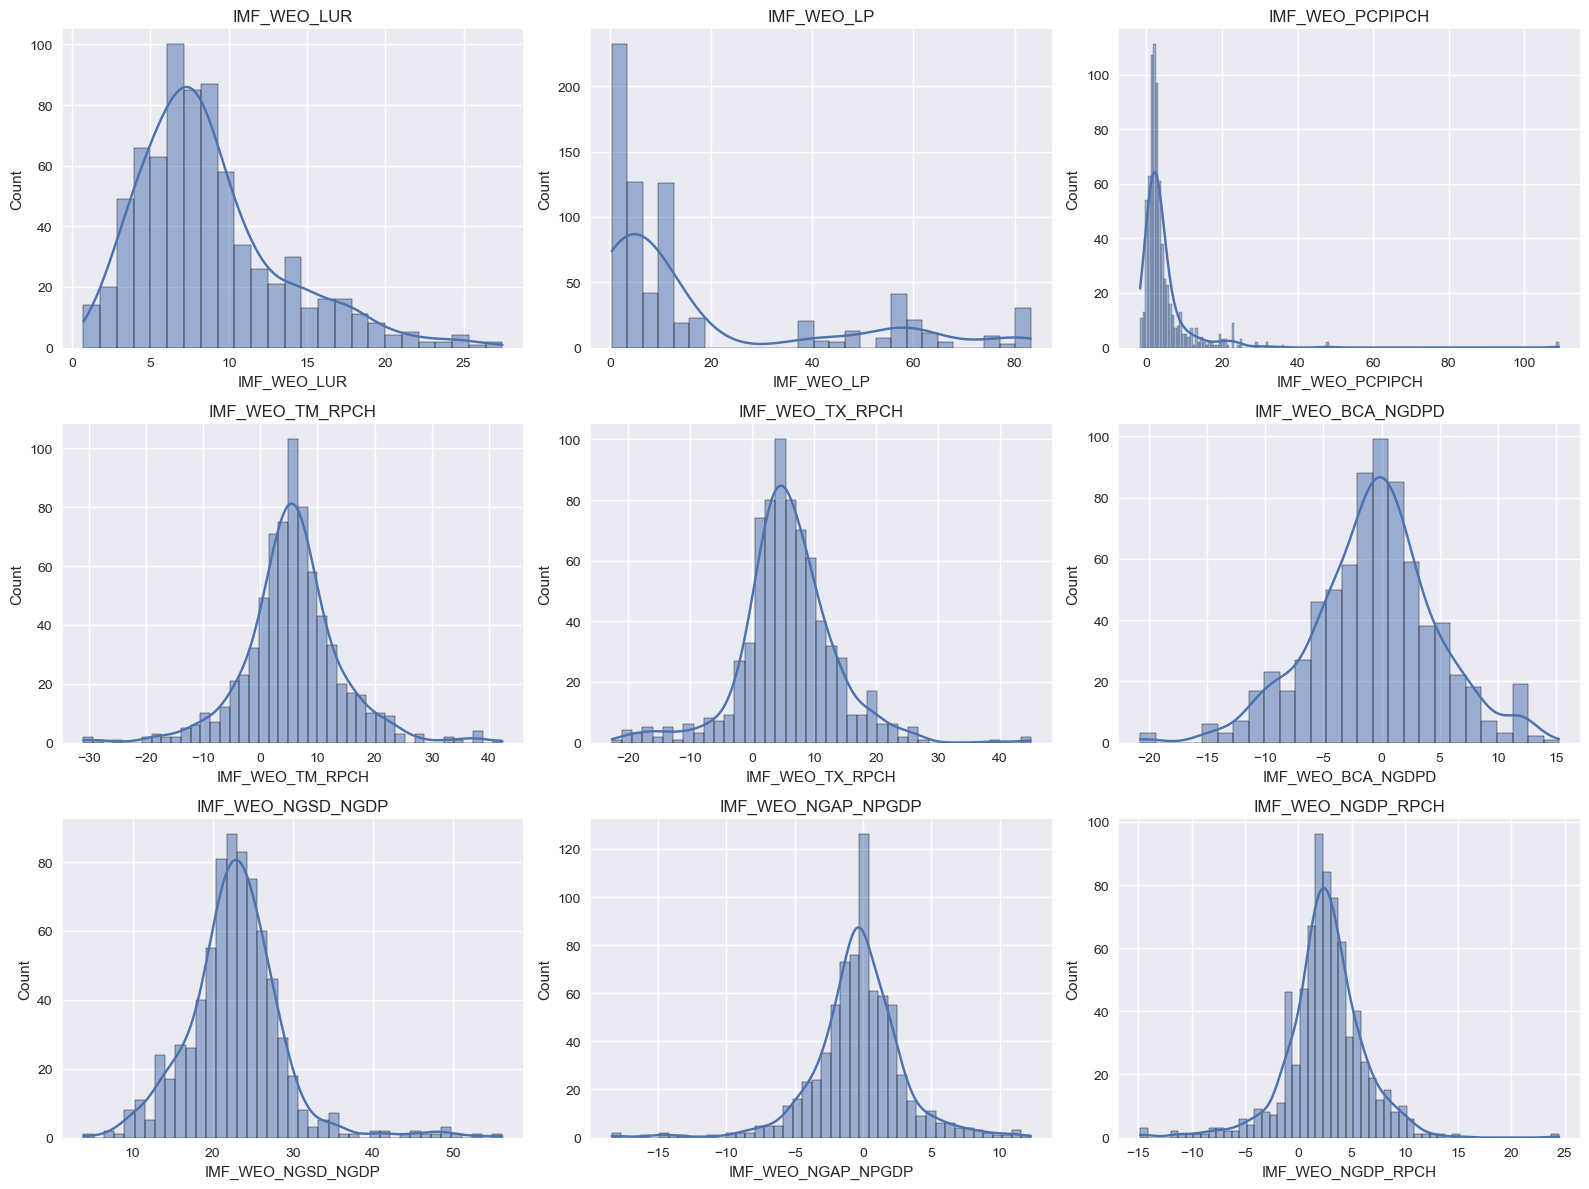

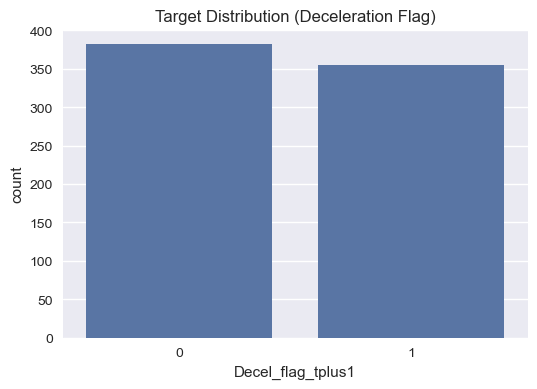

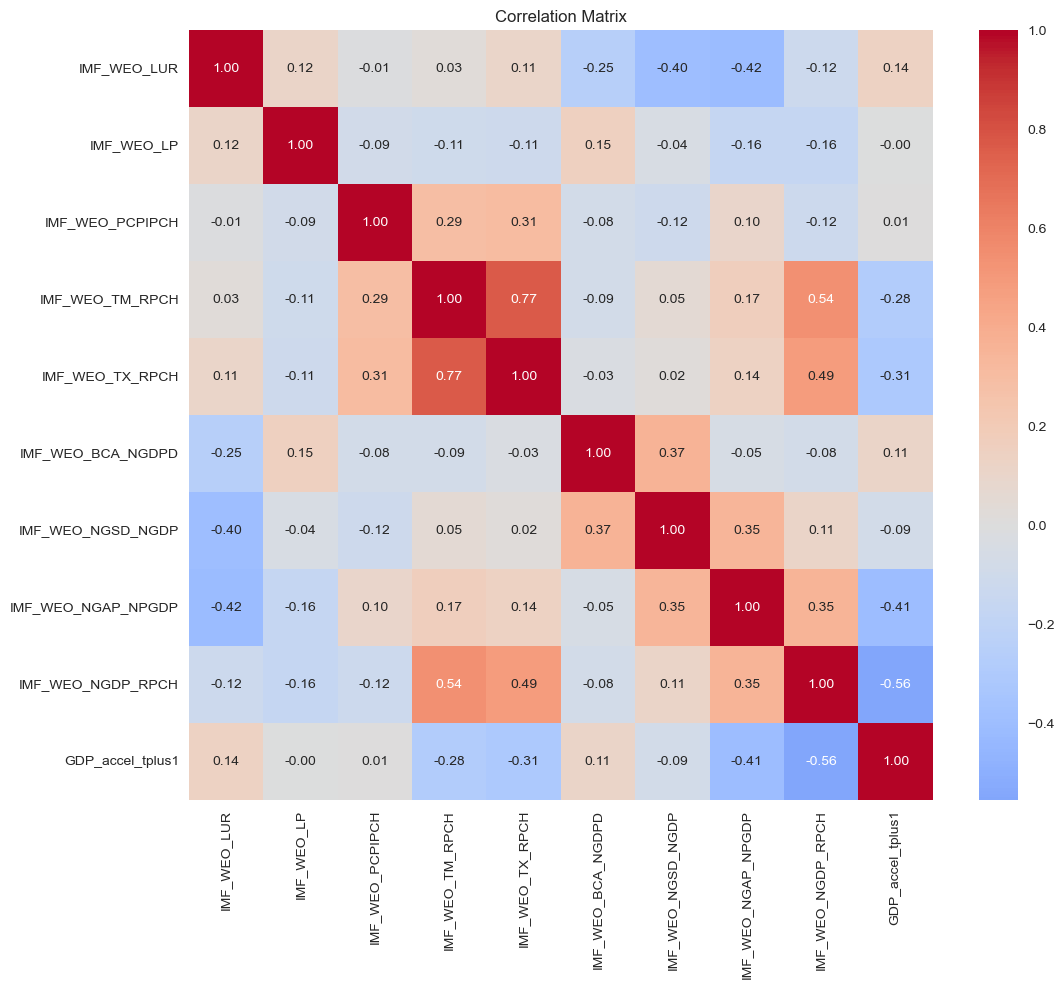

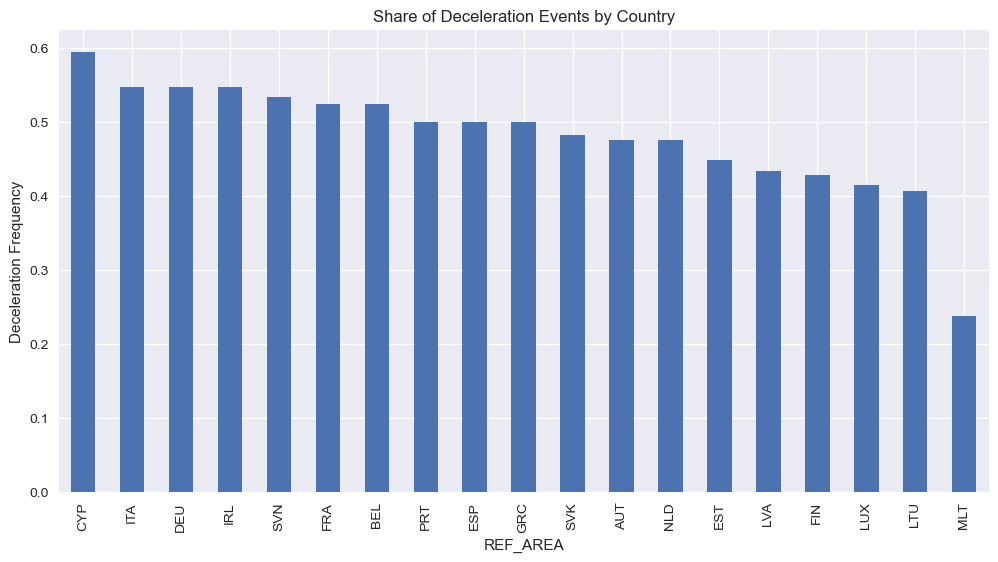

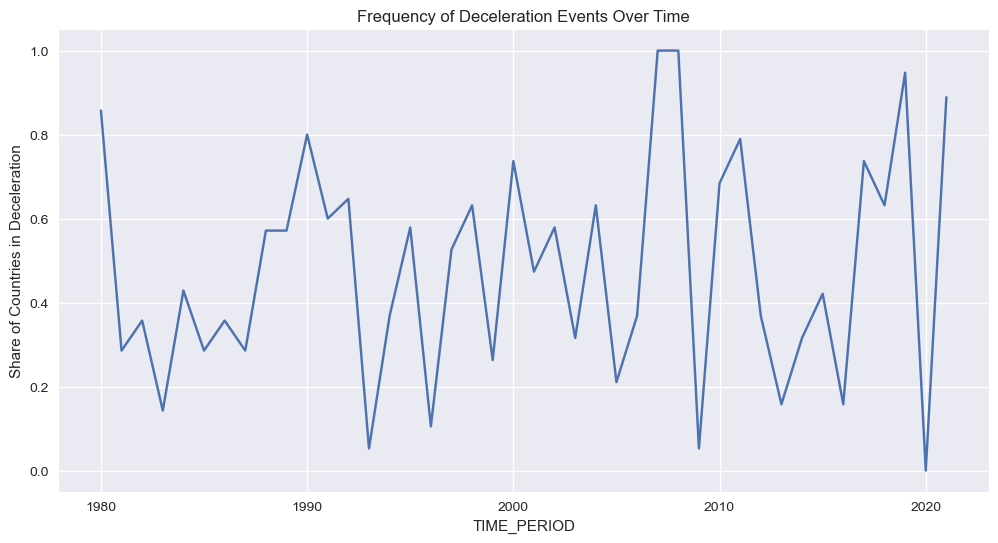

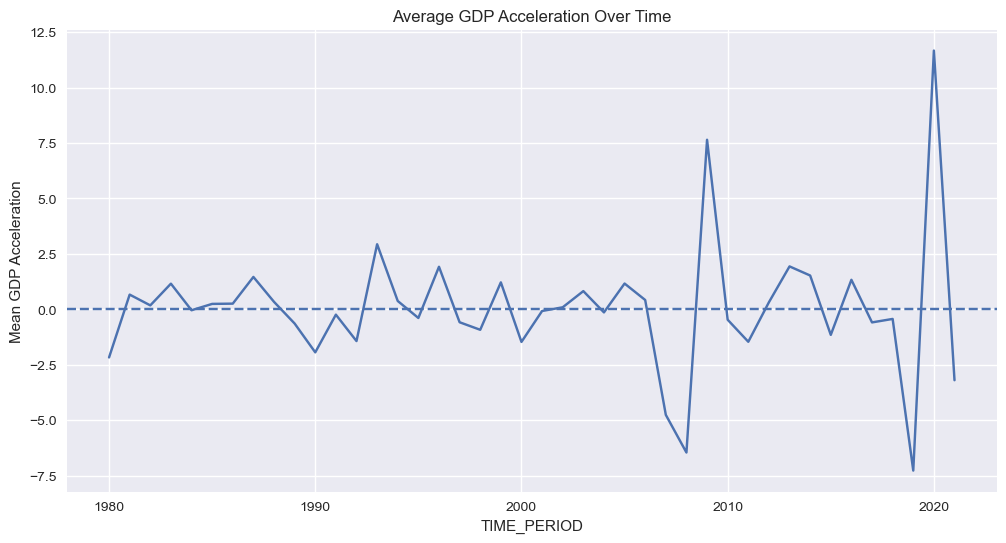

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------------------------
# Basic settings
# ---------------------------------
plt.style.use("seaborn-v0_8")
sns.set_palette("deep")

FEATURES = [
    "IMF_WEO_LUR",
    "IMF_WEO_LP",
    "IMF_WEO_PCPIPCH",
    "IMF_WEO_TM_RPCH",
    "IMF_WEO_TX_RPCH",
    "IMF_WEO_BCA_NGDPD",
    "IMF_WEO_NGSD_NGDP",
    "IMF_WEO_NGAP_NPGDP",
    "IMF_WEO_NGDP_RPCH"
]

TARGET = "Decel_flag_tplus1"

# =========================================
# Feature Distributions
# =========================================

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(FEATURES):
    sns.histplot(df_ml_ready[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


# =========================================
# Target Distribution
# =========================================

plt.figure(figsize=(6,4))
sns.countplot(x=TARGET, data=df_ml_ready)
plt.title("Target Distribution (Deceleration Flag)")
plt.show()


# =========================================
# Correlation Matrix
# =========================================

plt.figure(figsize=(12,10))
corr_matrix = df_ml_ready[FEATURES + ["GDP_accel_tplus1"]].corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)

plt.title("Correlation Matrix")
plt.show()


# =========================================
# Distribution of Target by Country
# =========================================

country_target = (
    df_ml_ready
    .groupby("REF_AREA")[TARGET]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
country_target.plot(kind="bar")
plt.title("Share of Deceleration Events by Country")
plt.ylabel("Deceleration Frequency")
plt.show()


# =========================================
# Frequency of Decelerations Over Time
# =========================================

time_target = (
    df_ml_ready
    .groupby("TIME_PERIOD")[TARGET]
    .mean()
)

plt.figure(figsize=(12,6))
time_target.plot()
plt.title("Frequency of Deceleration Events Over Time")
plt.ylabel("Share of Countries in Deceleration")
plt.show()


# =========================================
# Average GDP Acceleration Over Time
# =========================================

gdp_accel_time = (
    df_ml_ready
    .groupby("TIME_PERIOD")["GDP_accel_tplus1"]
    .mean()
)

plt.figure(figsize=(12,6))
gdp_accel_time.plot()
plt.title("Average GDP Acceleration Over Time")
plt.ylabel("Mean GDP Acceleration")
plt.axhline(0, linestyle="--")
plt.show()



**Insights:**
- Feature histograms → check distribution shape, skewness
- Target countplot → confirm balance
- Correlation matrix → multicollinearity sanity
- Target by country → heterogeneity analysis
- Target over time → cycle detection
- GDP acceleration average → macroeconomic dynamics


### 19. final EDA interpretation

1. **Feature Distributions**
>
- Most macro variables show approximately bell-shaped distributions (e.g., unemployment, trade growth, fiscal balance).
>
- Some variables (inflation, labor productivity) show right skewness and occasional extreme values.
>
- Trade variables (exports/imports growth) exhibit wider dispersion, reflecting higher volatility.
>
- No severe outliers or structural anomalies were detected after cleaning.
>
**Conclusion:**
 Feature distributions are economically plausible and suitable for modeling. Some skewness may justify standardization in later ML steps.


2. **Target Distribution (Decel_flag_tplus1)**
>
- The target is nearly balanced:
       - ~52% No deceleration
       - ~48% Deceleration
>
- This is ideal for classification:
       - No strong class imbalance
       - No need for resampling techniques
>
**Conclusion:**
 The dataset is naturally balanced, which strengthens classification reliability.

3. **Correlation Matrix**
>
Key observations:
>
- Export and import growth are highly correlated (expected).
>
- GDP growth is moderately correlated with trade variables.
>
- GDP acceleration (t+1) is negatively correlated with GDP growth at time t (~ -0.56), consistent with mean reversion dynamics.
>
- No extreme multicollinearity (>0.9) among final selected features.
>
**Conclusion:**
 The feature set maintains economic coherence without problematic multicollinearity.


4. **Share of Deceleration Events by Country**
>
- Some countries (e.g., CYP, ITA) exhibit higher deceleration frequency.
>
- Others (e.g., MLT, LTU) show lower frequencies.
>
- Variation reflects heterogeneous macroeconomic volatility within the Euro Area.
>
**Conclusion:**
 Despite belonging to the same region, countries display different cyclical sensitivities-useful signal for classification.


5. **Frequency of Deceleration Over Time**
>
- Clear clustering during crisis periods:
       - Early 1990s
       - 2008–2009 (Global Financial Crisis)
       - 2020 (COVID shock)
>
- Peaks correspond to known macroeconomic downturns.
>
**Conclusion:**
 The constructed target captures real macroeconomic cycles, validating its economic relevance.


6. **Average GDP Acceleration Over Time**
>
- Strong negative acceleration during:
      - 2008–2009
      - 2020
>
- Positive rebounds observed after crisis years.
>
- Mean-reverting dynamics visible over long horizon.
>
**Conclusion:**
 GDP acceleration behaves cyclically and supports the logic of modeling deceleration rather than level GDP growth.


**Final EDA Takeaway**
>
The dataset:
>
- Is economically coherent
>
- Is statistically well-behaved
>
- Captures real macro cycles
>
- Contains sufficient cross-country variation
>
- Has balanced classification target
>
- Shows no critical multicollinearity
>
>
→ The ML-ready dataset is robust and suitable for early-warning classification modeling.

### 19.

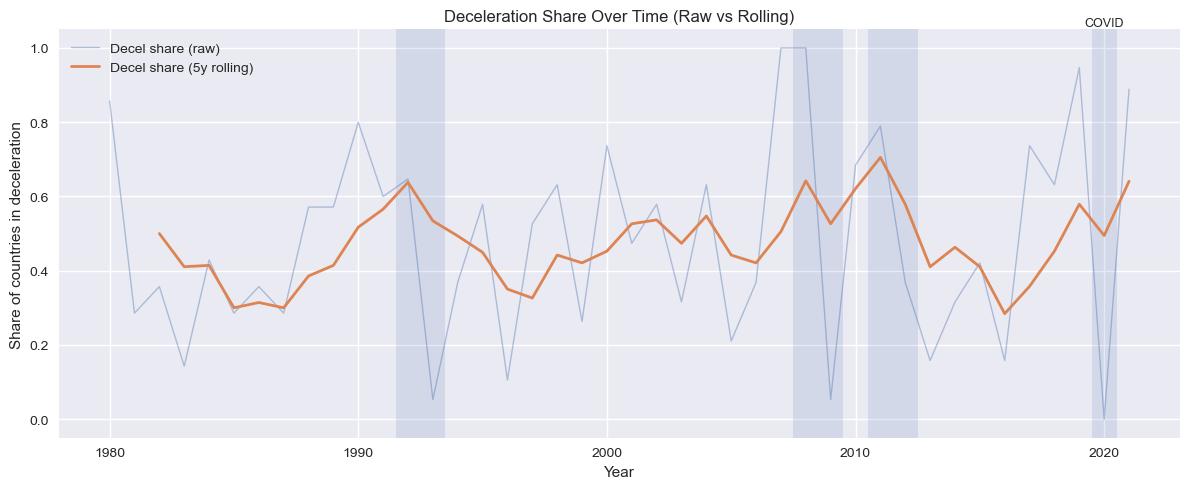

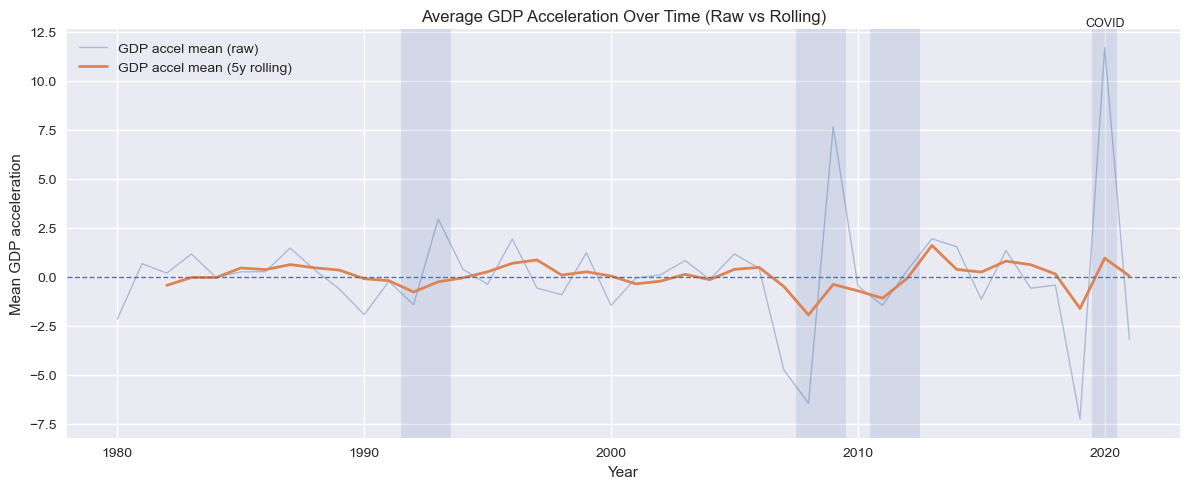

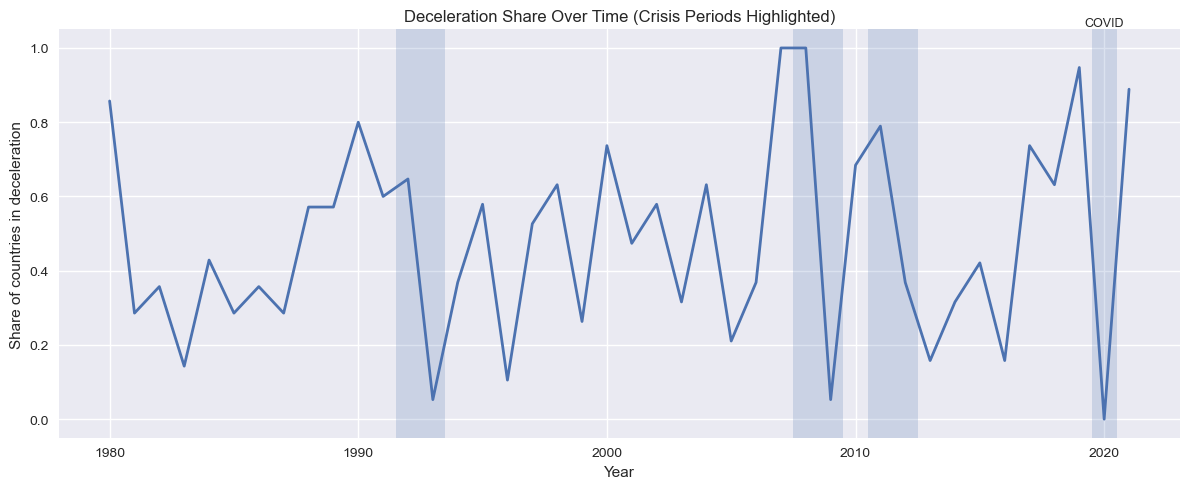

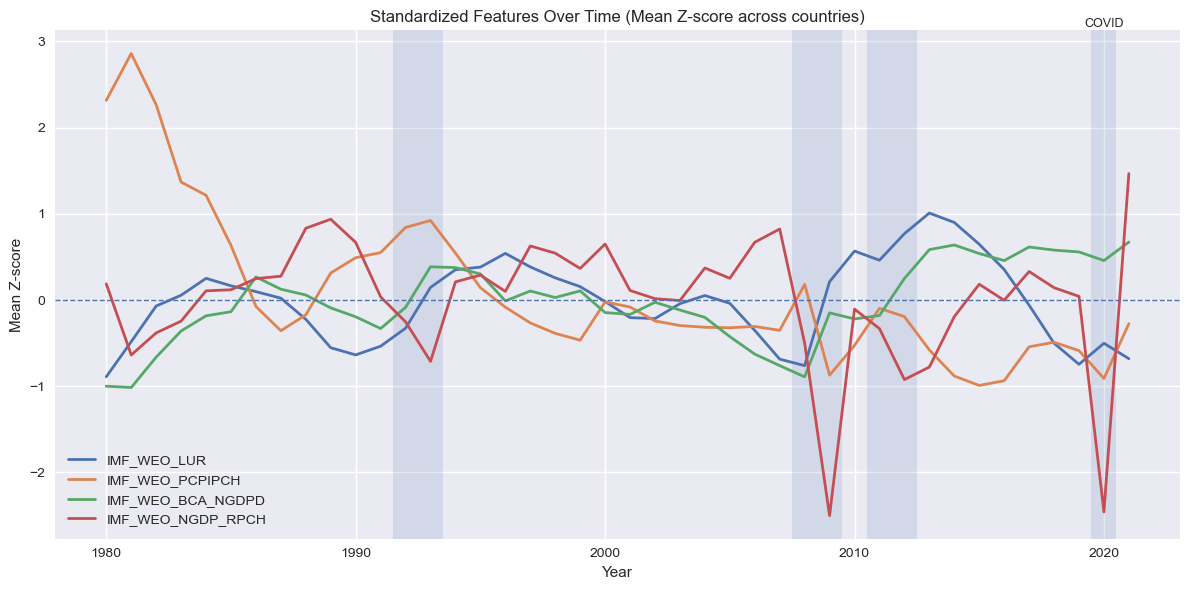

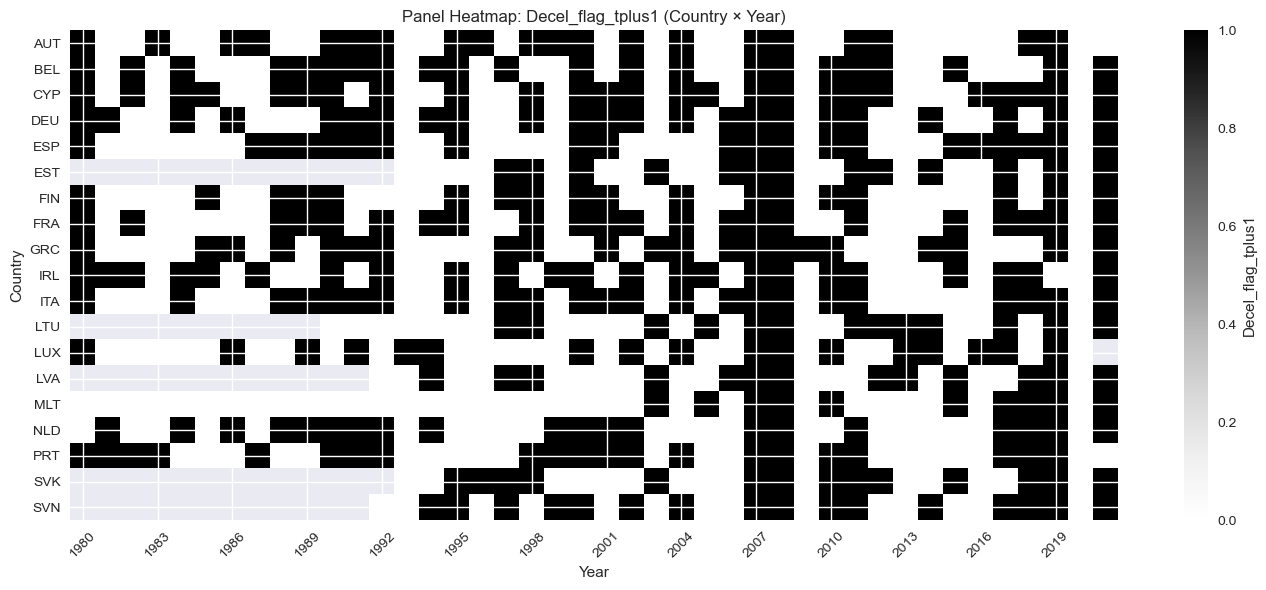

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assumes you already have df_ml_ready with at least:
# ['REF_AREA','TIME_PERIOD'] + FEATURES + ['GDP_accel_tplus1','Decel_flag_tplus1']

dfp = df_ml_ready.copy()
dfp["TIME_PERIOD"] = dfp["TIME_PERIOD"].astype(int)

FEATURES = [
"IMF_WEO_LUR",
"IMF_WEO_LP",
"IMF_WEO_PCPIPCH",
"IMF_WEO_TM_RPCH",
"IMF_WEO_TX_RPCH",
"IMF_WEO_BCA_NGDPD",
"IMF_WEO_NGSD_NGDP",
"IMF_WEO_NGAP_NPGDP",
"IMF_WEO_NGDP_RPCH",
]

# Crisis periods to shade (edit if you want)
CRISIS_PERIODS = [
("ERM crisis / early 90s", 1992, 1993),
("Global Financial Crisis", 2008, 2009),
("Euro Area sovereign crisis", 2011, 2012),
("COVID", 2020, 2020),
]

def shade_crises(ax, crisis_periods=CRISIS_PERIODS, alpha=0.15):
 ymin, ymax = ax.get_ylim()
 for label, start, end in crisis_periods:
  ax.axvspan(start - 0.5, end + 0.5, alpha=alpha)
# Optional: label the last one (avoid clutter)
 if crisis_periods:
  label, start, end = crisis_periods[-1]
 ax.text((start+end)/2, ymax, label, ha="center", va="bottom", fontsize=9)

# ============================================================
# 1) Rolling average smoothing (share of deceleration + accel)
# ============================================================
window = 5 # 5-year rolling window (edit)

yearly = (
dfp.groupby("TIME_PERIOD")
.agg(
decel_share=("Decel_flag_tplus1", "mean"),
accel_mean=("GDP_accel_tplus1", "mean")
)
.sort_index()
)

yearly["decel_share_roll"] = yearly["decel_share"].rolling(window, min_periods=3).mean()
yearly["accel_mean_roll"] = yearly["accel_mean"].rolling(window, min_periods=3).mean()

plt.figure(figsize=(12, 5))
plt.plot(yearly.index, yearly["decel_share"], linewidth=1, alpha=0.4, label="Decel share (raw)")
plt.plot(yearly.index, yearly["decel_share_roll"], linewidth=2, label=f"Decel share ({window}y rolling)")
plt.title("Deceleration Share Over Time (Raw vs Rolling)")
plt.xlabel("Year")
plt.ylabel("Share of countries in deceleration")
ax = plt.gca()
shade_crises(ax)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(yearly.index, yearly["accel_mean"], linewidth=1, alpha=0.4, label="GDP accel mean (raw)")
plt.plot(yearly.index, yearly["accel_mean_roll"], linewidth=2, label=f"GDP accel mean ({window}y rolling)")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Average GDP Acceleration Over Time (Raw vs Rolling)")
plt.xlabel("Year")
plt.ylabel("Mean GDP acceleration")
ax = plt.gca()
shade_crises(ax)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 2) Highlight crisis periods (target share only, cleaner plot)
# ============================================================
plt.figure(figsize=(12, 5))
plt.plot(yearly.index, yearly["decel_share"], linewidth=2)
plt.title("Deceleration Share Over Time (Crisis Periods Highlighted)")
plt.xlabel("Year")
plt.ylabel("Share of countries in deceleration")
ax = plt.gca()
shade_crises(ax, alpha=0.20)
plt.tight_layout()
plt.show()

# ============================================================
# 3) Standardized plots (z-scores)
# Option: standardize within each country to remove levels
# ============================================================

# --- Standardize within country (recommended for panel comparability)
dfz = dfp.copy()
for c in FEATURES:
 dfz[c] = dfz.groupby("REF_AREA")[c].transform(lambda s: (s - s.mean()) / (s.std(ddof=0) if s.std(ddof=0) != 0 else 1))

# Plot standardized mean over time for a few key features (choose 3–5 max for readability)
feat_to_plot = ["IMF_WEO_LUR", "IMF_WEO_PCPIPCH", "IMF_WEO_BCA_NGDPD", "IMF_WEO_NGDP_RPCH"]

z_year = dfz.groupby("TIME_PERIOD")[feat_to_plot].mean().sort_index()

plt.figure(figsize=(12, 6))
for c in feat_to_plot:
 plt.plot(z_year.index, z_year[c], linewidth=2, label=c)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Standardized Features Over Time (Mean Z-score across countries)")
plt.xlabel("Year")
plt.ylabel("Mean Z-score")
ax = plt.gca()
shade_crises(ax)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 4) Panel heatmap (country × year)
# Heatmap of Decel_flag_tplus1 (0/1) OR GDP_accel_tplus1
# ============================================================

# --- Choose one:
HEATMAP_COL = "Decel_flag_tplus1" # binary heatmap
# HEATMAP_COL = "GDP_accel_tplus1" # continuous heatmap

pivot = dfp.pivot_table(
index="REF_AREA",
columns="TIME_PERIOD",
values=HEATMAP_COL,
aggfunc="mean"
).sort_index()

plt.figure(figsize=(14, 6))
# imshow expects numeric matrix; NaNs will appear blank if we mask them
data = pivot.values
masked = np.ma.masked_invalid(data)

plt.imshow(masked, aspect="auto", interpolation="nearest")
plt.title(f"Panel Heatmap: {HEATMAP_COL} (Country × Year)")
plt.xlabel("Year")
plt.ylabel("Country")

# Set year ticks (avoid overcrowding)
years = pivot.columns.to_list()
countries = pivot.index.to_list()

step = max(1, len(years)//12) # ~12 ticks
xticks = np.arange(0, len(years), step)
plt.xticks(xticks, [years[i] for i in xticks], rotation=45)

plt.yticks(np.arange(len(countries)), countries)

plt.colorbar(label=HEATMAP_COL) 
plt.tight_layout()
plt.show()


### 20. Interpretation of Final Time-Series Diagnostics

1. **Deceleration Share Over Time (Raw vs Rolling)**
>
The raw series shows substantial year-to-year volatility, reflecting heterogeneous country-specific shocks.
However, the 5-year rolling average reveals clearer cyclical patterns:
>
- A gradual rise in deceleration frequency during the early 1990s.
>
- A sharp and synchronized spike during 2008–2009.
>
- A strong increase again in 2020 (COVID shock).
> 
- A visible cyclical structure across decades rather than random noise.
>
**Interpretation:**
 The rolling smoothing confirms that deceleration events cluster around macroeconomic crises and follow medium-term cycles, validating the economic meaning of the constructed target.


2. **GDP Acceleration (Raw vs Rolling)**
>
The raw GDP acceleration series shows extreme spikes during crisis years:
>
- Large negative acceleration in 2008–2009.
>
- Sharp rebound afterward (mean reversion).
>
- Major shock again in 2020.
>
>
The rolling average smooths extreme shocks and reveals:
>
- Long-term mean-reverting behavior.
>
- Persistent cyclical downturns around global shocks.
>
- No structural break suggesting instability in the definition.
>
**Interpretation:**
 GDP acceleration behaves as a cyclical variable with identifiable macro shocks, supporting its use as the underlying economic signal behind the classification target.


3. **Deceleration Share with Crisis Highlighting**
>
The highlighted crisis bands show clear alignment between:
>
- Crisis periods
>
- Spikes in deceleration frequency
>
>
Notably:
>
- 2008–2009 shows near-systemic deceleration across countries.
>
- 2020 exhibits an abrupt spike.
>
- Early 1990s also show coordinated slowdowns.
>
**Interpretation:**
 The target construction captures real macroeconomic downturns rather than random variation.
 This confirms that the model is trained on economically meaningful signals.


4. **Standardized Features Over Time (Z-Scores)**
>
After standardizing within country:
>
- Unemployment rises during crisis periods.
>
- GDP growth (standardized) drops sharply during 2008 and 2020.
>
- Fiscal balances deteriorate during downturns.
>
- Inflation fluctuates but does not spike uniformly across crises.
>
>
The standardized representation removes country-level structural differences and highlights synchronized macro dynamics.
>
**Interpretation:**
 Macro variables co-move around crisis periods, suggesting that early-warning signals may be embedded in joint movements of unemployment, growth, and fiscal indicators.


> **Overall Conclusion from Time-Series Diagnostics**
>
These plots confirm:
>
- The dataset captures real macroeconomic cycles.
>
- The target aligns with known crisis events.
>
- GDP acceleration behaves cyclically and exhibits mean reversion.
>
- Features display synchronized macro dynamics during downturns.
>
→ The ML problem is economically grounded, not purely statistical.



### 21. Heatmaps

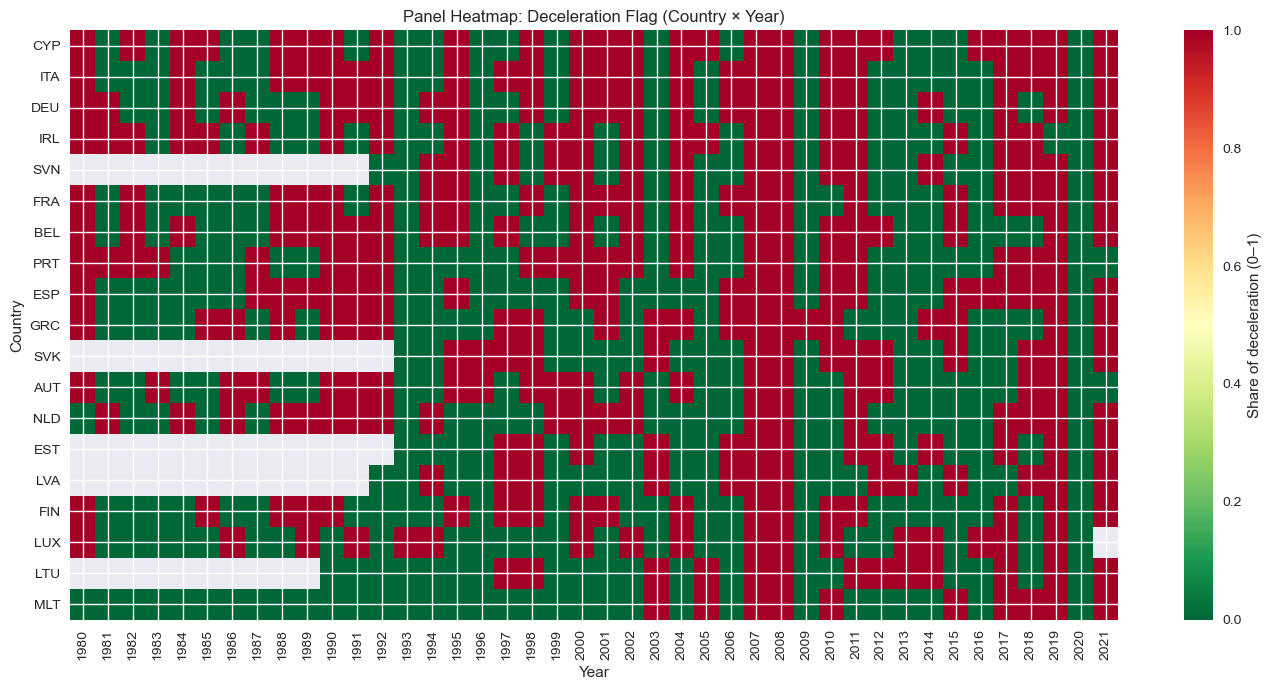

In [127]:
# Heatmap (country × year) from the target Decel_flag_tplus1 (0/1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dfp = df_ml_ready.copy()
dfp["TIME_PERIOD"] = dfp["TIME_PERIOD"].astype(int)

# Pivot: rows=countries, cols=years, values=target
mat = dfp.pivot_table(
index="REF_AREA",
columns="TIME_PERIOD",
values="Decel_flag_tplus1",
aggfunc="mean"
)

# Order countries by average decel rate (optional but nice)
mat = mat.loc[mat.mean(axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(14, 7))

# Colored heatmap
im = ax.imshow(mat.values, aspect="auto", interpolation="nearest", cmap="RdYlGn_r")
# RdYlGn_r => rojo = más decel, verde = menos decel

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Share of deceleration (0–1)")

# Axis labels / ticks
ax.set_title("Panel Heatmap: Deceleration Flag (Country × Year)")
ax.set_xlabel("Year")
ax.set_ylabel("Country")

ax.set_xticks(np.arange(mat.shape[1]))
ax.set_xticklabels(mat.columns, rotation=90)
ax.set_yticks(np.arange(mat.shape[0]))
ax.set_yticklabels(mat.index)

plt.tight_layout()
plt.show()


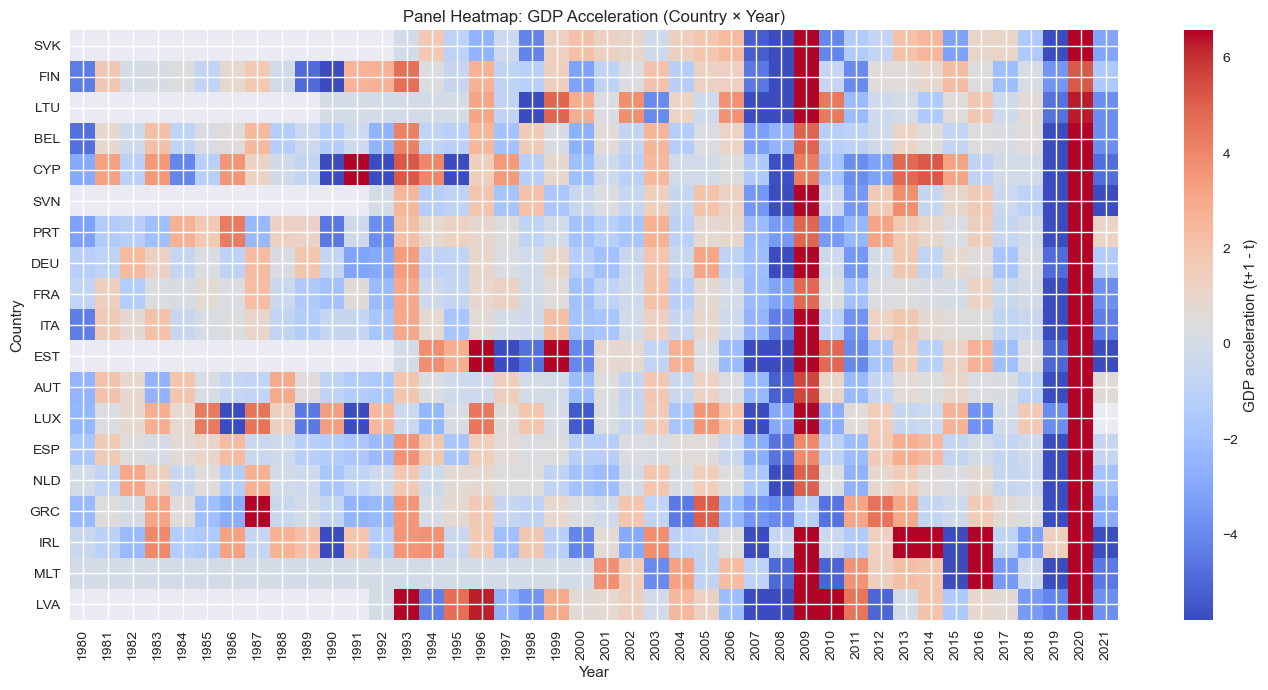

In [128]:
# Heatmap (country × year) from GDP_accel_tplus1 (continuos)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dfp = df_ml_ready.copy()
dfp["TIME_PERIOD"] = dfp["TIME_PERIOD"].astype(int)

mat_accel = dfp.pivot_table(
index="REF_AREA",
columns="TIME_PERIOD",
values="GDP_accel_tplus1",
aggfunc="mean"
)

# Optional: order by average acceleration
mat_accel = mat_accel.loc[mat_accel.mean(axis=1).sort_values().index]

fig, ax = plt.subplots(figsize=(14, 7))

# Robust color limits so outliers don't ruin the scale
vmin, vmax = np.nanpercentile(mat_accel.values, [5, 95])

im = ax.imshow(
mat_accel.values,
aspect="auto",
interpolation="nearest",
cmap="coolwarm", # azul = negativo, rojo = positivo
vmin=vmin,
vmax=vmax
)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("GDP acceleration (t+1 - t)")

ax.set_title("Panel Heatmap: GDP Acceleration (Country × Year)")
ax.set_xlabel("Year")
ax.set_ylabel("Country")

ax.set_xticks(np.arange(mat_accel.shape[1]))
ax.set_xticklabels(mat_accel.columns, rotation=90)
ax.set_yticks(np.arange(mat_accel.shape[0]))
ax.set_yticklabels(mat_accel.index)

plt.tight_layout()
plt.show()


> Insigth: The heatmaps confirm that deceleration events cluster around systemic shocks and display meaningful cross-country heterogeneity, validating both the economic logic and predictive potential of our classification target.


### 22. Next steps (for ML Phase)


> The dataset is ML-ready and suitable for supervised classification modeling.
>
>
**Recommended next steps:**
>
1. Define X (features) and Y (Decel_flag_tplus1
) explicitly from the ML-ready dataset.
2. Apply time-based train/test split. Baseline evaluation may use pre-COVID period (e.g., train ≤ 2016, test 2017–2019). Robustness checks should evaluate post-2020 crisis performance.
3. Train baseline Logistic Regression model.
4. Evaluate using AUC, F1-score, Precision, and Recall.
5. Perform hyperparameter tuning (regularization strength).
6. Compare against at least one ensemble model (e.g., Random Forest, Gradient Boosting).
7. Analyze feature importance and interpret macroeconomic drivers of deceleration risk.
>
No additional preprocessing is required. The dataset contains no missing values, no duplicates, and no leakage variables.


